In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install datasets

In [3]:
from datasets import load_dataset, concatenate_datasets
import pandas as pd


dataset = load_dataset("amazon_polarity")


def stratified_sample(data, sample_fraction, seed=42):
   
    class_0 = data.filter(lambda x: x['label'] == 0)
    class_1 = data.filter(lambda x: x['label'] == 1)
    
    
    n_samples_class_0 = int(sample_fraction * len(class_0))
    n_samples_class_1 = int(sample_fraction * len(class_1))
    

    class_0_sample = class_0.shuffle(seed=seed).select(range(n_samples_class_0))
    class_1_sample = class_1.shuffle(seed=seed).select(range(n_samples_class_1))
    
    
    return concatenate_datasets([class_0_sample, class_1_sample])

train_data = stratified_sample(dataset["train"], sample_fraction=1)
test_data = stratified_sample(dataset["test"], sample_fraction=1)

print(train_data.features)
print(train_data['label'].count(0), train_data['label'].count(1))

README.md:   0%|          | 0.00/6.81k [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/260M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/258M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/254M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/400000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/400000 [00:00<?, ? examples/s]

{'label': ClassLabel(names=['negative', 'positive'], id=None), 'title': Value(dtype='string', id=None), 'content': Value(dtype='string', id=None)}
1800000 1800000


In [4]:
df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

print(f"Train Data Size: {len(df_train)}, Test Data Size: {len(df_test)}")

df_train = df_train[["content", "label"]]
df_test = df_test[["content", "label"]]

df_train.head()
print(df_train["content"].isna().sum()) 
print(df_test["content"].isna().sum())  

Train Data Size: 3600000, Test Data Size: 400000
0
0


In [5]:
import re

def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9!?]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip() 
    return text.lower()


    
df_train["content"]=df_train["content"].apply(clean_text)
df_test["content"]=df_test["content"].apply(clean_text)



In [6]:
#from sklearn.feature_extraction.text import TfidfVectorizer  

# Initialize TF-IDF
#vectorizer = TfidfVectorizer(max_features=10000)  # Limit features to 10,000

# Transform training and testing text data
#X_train = vectorizer.fit_transform(df_train['content'])
#X_test = vectorizer.transform(df_test['content'])

#y_train = df_train['label']
#y_test = df_test['label']



In [7]:
#from sklearn.linear_model import LogisticRegression  
#from sklearn.metrics import accuracy_score  

# Train model
#model = LogisticRegression(max_iter=200)
#model.fit(X_train, y_train)

# Predict on test set
#y_pred = model.predict(X_test)

# Evaluate
#accuracy = accuracy_score(y_test, y_pred)
#print(f"Accuracy: {accuracy:.4f}")


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_VOCAB_SIZE =10000
MAX_SEQUENCE_LENGTH=200

In [9]:
tokenizer=Tokenizer(num_words=MAX_VOCAB_SIZE,oov_token="<OOV>")
tokenizer.fit_on_texts(df_train["content"])

train_sequences=tokenizer.texts_to_sequences(df_train["content"])
test_sequences=tokenizer.texts_to_sequences(df_test["content"])

train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post")

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_padded, df_train["label"]))
test_dataset = tf.data.Dataset.from_tensor_slices((test_padded, df_test["label"]))

BATCH_SIZE = 128

train_dataset = train_dataset.shuffle(buffer_size=len(train_padded)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for batch in train_dataset.take(1):
    print("Input shape:", batch[0].shape)  
    print("Label shape:", batch[1].shape) 

Input shape: (128, 200)
Label shape: (128,)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional,Conv1D,GlobalAveragePooling1D,BatchNormalization,MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.layers import GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.mixed_precision import set_global_policy


model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(24, return_sequences=True, kernel_regularizer=l2(0.002))),
    Dropout(0.4),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu', kernel_regularizer=l2(0.002)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])


model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=['accuracy']
    )


model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    train_dataset,
    epochs=20, 
    validation_data=test_dataset,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/20
28125/28125 ━━━━━━━━━━━━━━━━━━━━ 694s 24ms/step - accuracy: 0.8909 - loss: 0.2965 - val_accuracy: 0.9215 - val_loss: 0.2090 - learning_rate: 0.0010
Epoch 2/20
28125/28125 ━━━━━━━━━━━━━━━━━━━━ 693s 24ms/step - accuracy: 0.9189 - loss: 0.2267 - val_accuracy: 0.9267 - val_loss: 0.1964 - learning_rate: 0.0010
Epoch 3/20
28125/28125 ━━━━━━━━━━━━━━━━━━━━ 693s 24ms/step - accuracy: 0.9245 - loss: 0.2139 - val_accuracy: 0.9253 - val_loss: 0.1994 - learning_rate: 0.0010
Epoch 4/20
28125/28125 ━━━━━━━━━━━━━━━━━━━━ 687s 24ms/step - accuracy: 0.9277 - loss: 0.2071 - val_accuracy: 0.9314 - val_loss: 0.1878 - learning_rate: 0.0010
Epoch 5/20
28125/28125 ━━━━━━━━━━━━━━━━━━━━ 690s 24ms/step - accuracy: 0.9300 - loss: 0.2020 - val_accuracy: 0.9312 - val_loss: 0.1877 - learning_rate: 0.0010
Epoch 6/20
28125/28125 ━━━━━━━━━━━━━━━━━━━━ 710s 25ms/step - accuracy: 0.9315 - loss: 0.1989 - val_accuracy: 0.9251 - val_loss: 0.1991 - learning_rate: 0.0010
Epoch 7/20
28125/28125 ━━━━━━━━━━━━━━━━━━━━ 70

In [13]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc * 100:.2f}%") 


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.9387 - loss: 0.1713
Test Accuracy: 93.55%


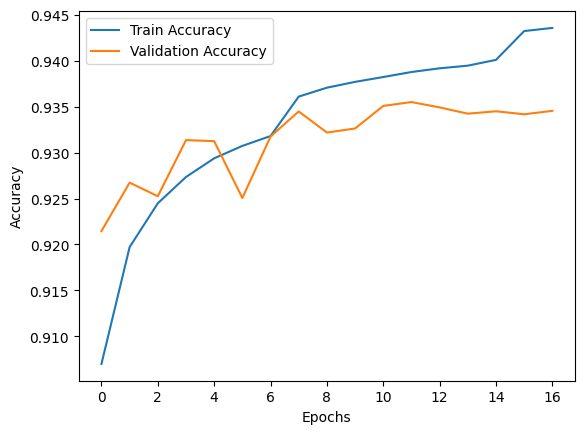

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [15]:
y_pred_probs = model.predict(test_dataset) 
y_pred = (y_pred_probs > 0.5).astype(int)  

from sklearn.metrics import classification_report

print(classification_report(df_test["label"], y_pred))


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step
              precision    recall  f1-score   support

           0       0.93      0.94      0.94    200000
           1       0.94      0.93      0.94    200000

    accuracy                           0.94    400000
   macro avg       0.94      0.94      0.94    400000
weighted avg       0.94      0.94      0.94    400000



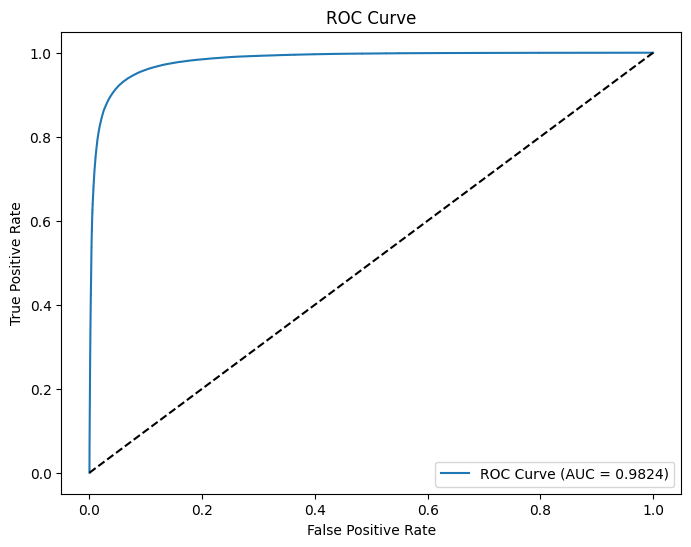

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(df_test["label"], y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [17]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_sentence(model, tokenizer, sentence, max_length=MAX_SEQUENCE_LENGTH):
    
    sequence = tokenizer.texts_to_sequences([sentence])
    
    
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    prediction = model.predict(padded_sequence)[0][0]  

  
    label = 1 if prediction >= 0.5 else 0

    return label, prediction


test_sentence = "Back vent not given"
label, probability = predict_sentence(model, tokenizer, test_sentence)

print(f"Predicted Label: {label}, Probability: {probability:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
Predicted Label: 1, Probability: 0.6236


In [18]:
model.save("sentiment_analysis_final.keras")
import pickle
import os


os.makedirs('/kaggle/working/sentiment_model', exist_ok=True)

with open('/kaggle/working/sentiment_model/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("Tokenizer saved successfully to /kaggle/working/sentiment_model!")


Tokenizer saved successfully to /kaggle/working/sentiment_model!
